## 평가문항
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.

	모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.

	regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

	Accuracy 기준 85%에 도달하였다.

### 목차

1. 학습데이터 구축
    - 데이터 분리
    - 이미지 전처리  
        (1) 정규화  
        (2) augmentation  
        (3) 시각화
2. 모델 설계
3. 모델 학습
    - augemtation 미적용
    - augemtation 적용
4. 결과 시각화

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# !unzip '/content/drive/MyDrive/aiffel/archive (2).zip' -d .

## 1. 학습 데이터 구축

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel') # lms
# ROOT_PATH  = '/content/' # colab

TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray//data/val/'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/'

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH +'*/*')
test_filenames = tf.io.gfile.glob(TEST_PATH +'*/*' )
val_filenames = tf.io.gfile.glob(VAL_PATH +'*/*')

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# class balance 확인
print('Train NORMAL : ',len(os.listdir(TRAIN_PATH+"/NORMAL")))
print('Train PNEUMONIA : ', len(os.listdir(TRAIN_PATH+"/PNEUMONIA")))

Train NORMAL :  1341
Train PNEUMONIA :  3875


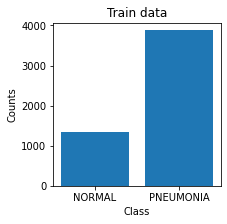

In [6]:
plt.figure(figsize = (3,3))
plt.bar([0,1],[len(os.listdir(TRAIN_PATH+"/NORMAL")),len(os.listdir(TRAIN_PATH+"/PNEUMONIA"))])
plt.title('Train data')
plt.xticks([0,1], labels =['NORMAL','PNEUMONIA'])
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

### 데이터 분리

In [149]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다.
filenames = tf.io.gfile.glob(TRAIN_PATH+ '*/*')
# filenames.extend(tf.io.gfile.glob(VAL_PATH+ '*/*'))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)

random.seed(8)

random.shuffle(filenames)

train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4172
1044


In [150]:
# 이름 형식 확인
print(f'Normal image path:\n{filenames[0]}')
print(f'Pneumonia image path:\n{filenames[2000]}')

Normal image path:
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1592_virus_2766.jpeg
Pneumonia image path:
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1242_bacteria_3198.jpeg


In [151]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1065
Pneumonia images count in training set: 3107


In [152]:
COUNT_NORMAL = len([filename for filename in val_filenames if "NORMAL" in filename])
print(f"Normal images count in valid set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in valid set: {COUNT_PNEUMONIA}")

Normal images count in valid set: 276
Pneumonia images count in valid set: 768


데이터셋 만들기

In [153]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [154]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4172
Validating images count: 1044


### 이미지 파일 전처리

- 정규화
- augmentation

#### (1) 정규화

In [156]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [157]:
# preocessing 적용

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [158]:
for image, label in train_ds.take(1): # 임의의 데이터 확인
    print("Image shape: ", image.numpy().shape) # 180,180 사이즈 일괄 적용
    print("Label: ", label.numpy()) # False, True label 적용

Image shape:  (180, 180, 3)
Label:  True


In [159]:
for image, label in train_ds.take(1): # 임의의 데이터 확인
    print("Image shape: ", image.numpy().shape) # 180,180 사이즈 일괄 적용
    print("Label: ", label.numpy()) # False, True label 적용

Image shape:  (180, 180, 3)
Label:  True


In [160]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16

In [161]:
# test 도 train과 동일한 과정을 거침
test_list_ds = tf.data.Dataset.list_files(test_filenames)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### (2) Augmentation

In [162]:
input_shape = [180, 180, 3]

def augment(image,label):

    # Random B/S changes
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0) # keeping pixel values in check

    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)

    return image,label


In [163]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### (3) 학습 이미지 시각화

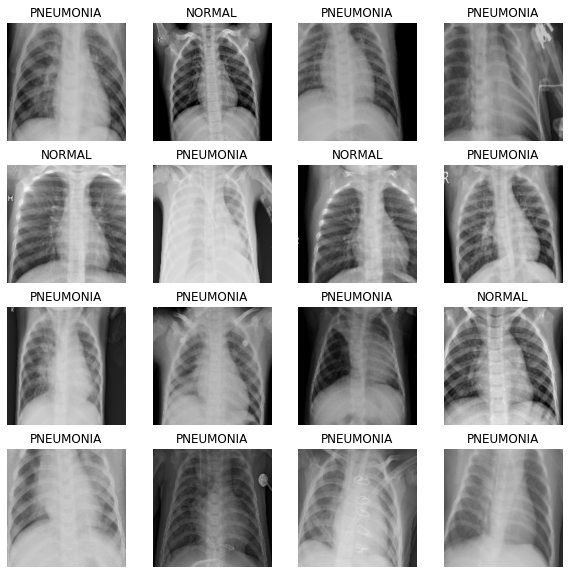

In [21]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,math.ceil(16/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2. 모델 설계

### RESNET-18

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

3x3 CNN
BatchNormalization
로 구성되어 있습니다.

![Residual Connection (출처 : https://paperswithcode.com/method/residual-block)](https://d3s0tskafalll9.cloudfront.net/media/images/residual_connection.max-800x600.png)



위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

![ResNet-18 모델 (출처 : ResNet Paper)](https://d3s0tskafalll9.cloudfront.net/media/images/resnet-18.max-800x600.png)

In [114]:
def identity_block(input_tensor, filter, stride = 1, kernel = 3):
    x = tf.keras.layers.Conv2D(filters=filter,
                                        kernel_size=(3, 3),
                                        strides=stride,
                                        kernel_initializer='he_normal',
                                        padding="same")(input_tensor)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Conv2D(filters=filter,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        kernel_initializer='he_normal',
                                        padding="same")(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    shortcut = input_tensor
    if stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters=filter,
                                            kernel_size=(1, 1),
                                            strides=stride,
                                            kernel_initializer='he_normal')(input_tensor)
        shortcut = tf.keras.layers.BatchNormalization(axis=3)(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def loop_block(inputs, filter, loop, stride=1):
    x = identity_block(inputs, filter, stride=stride)

    for _ in range(1, loop):
        x = identity_block(x, filter, stride=1)
    return x

In [119]:
def resnet18(include_top=False, weights=None, input_shape=None, layer_params=[2, 2, 2, 2], pooling=None):
    input_shape = [180,180,3]
    img_input = tf.keras.layers.Input(shape=input_shape)


    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = tf.keras.layers.Conv2D(32, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)


    x = loop_block(x, filter=32,
                          loop=layer_params[0])
    x = loop_block(x, filter=64,
                          loop=layer_params[1],
                          stride=2)
    x = loop_block(x, filter=128,
                          loop=layer_params[2],
                          stride=2)
    x = loop_block(x, filter=256,
                          loop=layer_params[3],
                          stride=2)

    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)

    model = tf.keras.Model(img_input, x, name='resnet18')
    return model

### 구축한 resnet-18 모델 구조 확인 (몹시 긺 주의)

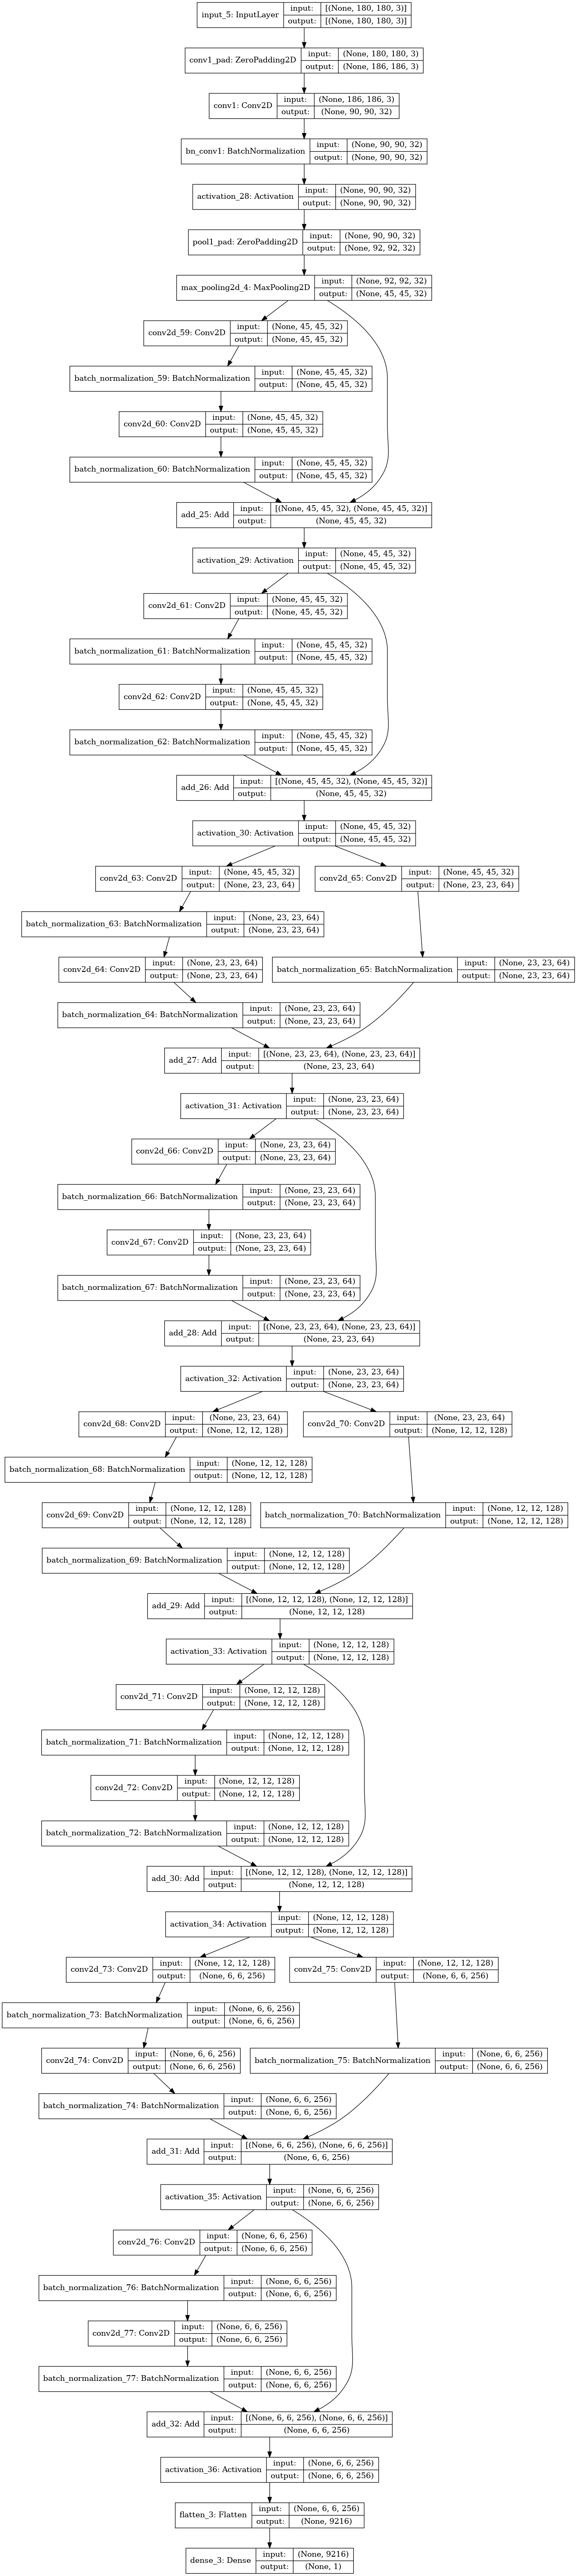

In [121]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 3. 모델 학습

### Data_augmentation 없이 모델 학습

In [164]:
model_na = resnet18()

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 7.56
Weight for PNEUMONIA: 2.72


In [168]:
with tf.device('/GPU:0'):
    model_na = resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model_na.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [169]:
with tf.device('/GPU:0'):
    history = model_na.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = es
    )

Epoch 1/100
260/260 [==============================] - 61s 200ms/step - loss: 1.6063 - accuracy: 0.9171 - precision: 0.9680 - recall: 0.9189 - val_loss: 0.4729 - val_accuracy: 0.8635 - val_precision: 0.8442 - val_recall: 0.9987
Epoch 2/100
260/260 [==============================] - 51s 199ms/step - loss: 0.7550 - accuracy: 0.9459 - precision: 0.9819 - recall: 0.9449 - val_loss: 0.3596 - val_accuracy: 0.9375 - val_precision: 0.9268 - val_recall: 0.9935
Epoch 3/100
260/260 [==============================] - 52s 200ms/step - loss: 0.4741 - accuracy: 0.9644 - precision: 0.9881 - recall: 0.9638 - val_loss: 0.4434 - val_accuracy: 0.8692 - val_precision: 0.9906 - val_recall: 0.8298
Epoch 4/100
260/260 [==============================] - 51s 199ms/step - loss: 0.4099 - accuracy: 0.9683 - precision: 0.9898 - recall: 0.9674 - val_loss: 4.5886 - val_accuracy: 0.4519 - val_precision: 1.0000 - val_recall: 0.2559
Epoch 5/100
260/260 [==============================] - 53s 205ms/step - loss: 0.2274 - a

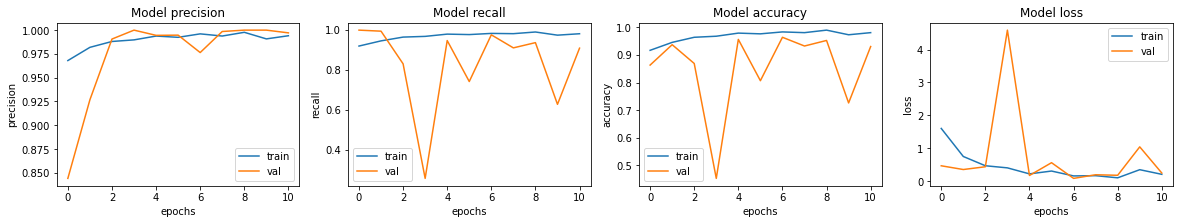

In [171]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [170]:
loss, accuracy, precision, recall = model.evaluate(test_ds) # test_ds 고치고나서는 evaluate 가능
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

1/1 [==============================] - 5s 5s/step - loss: 15.0027 - accuracy: 0.3798 - precision: 0.8000 - recall: 0.0103
Loss: 15.002680778503418,
Accuracy: 0.3798076808452606,
Precision: 0.800000011920929,
Recall: 0.010256410576403141


### Augmenation 적용하여 학습

In [120]:
model = resnet18()

model.summary()

Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 90, 90, 32)   4736        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 90, 90, 32)   128         conv1[0][0]                      
___________________________________________________________________________________________

In [122]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 7.73
Weight for PNEUMONIA: 2.70


In [126]:
with tf.device('/GPU:0'):
    model = resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [127]:
es = EarlyStopping(
    monitor='loss',
    min_delta = 0.0005,
    mode = 'auto',
    patience=2,
    verbose=1)

In [128]:
BATCH_SIZE

16

In [131]:
EPOCHS = 100

In [132]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = es
    )

Epoch 1/100
260/260 [==============================] - 62s 208ms/step - loss: 0.9649 - accuracy: 0.9082 - precision: 0.9689 - recall: 0.9056 - val_loss: 0.2727 - val_accuracy: 0.8933 - val_precision: 0.8903 - val_recall: 0.9767
Epoch 2/100
260/260 [==============================] - 54s 209ms/step - loss: 0.9731 - accuracy: 0.9108 - precision: 0.9703 - recall: 0.9078 - val_loss: 0.3053 - val_accuracy: 0.8913 - val_precision: 0.9508 - val_recall: 0.9003
Epoch 3/100
260/260 [==============================] - 54s 207ms/step - loss: 0.7126 - accuracy: 0.9310 - precision: 0.9789 - recall: 0.9273 - val_loss: 0.3643 - val_accuracy: 0.8558 - val_precision: 0.9984 - val_recall: 0.8067
Epoch 4/100
260/260 [==============================] - 55s 211ms/step - loss: 0.8650 - accuracy: 0.9240 - precision: 0.9753 - recall: 0.9211 - val_loss: 0.2867 - val_accuracy: 0.8769 - val_precision: 0.8608 - val_recall: 0.9948
Epoch 5/100
260/260 [==============================] - 55s 212ms/step - loss: 0.6369 - a

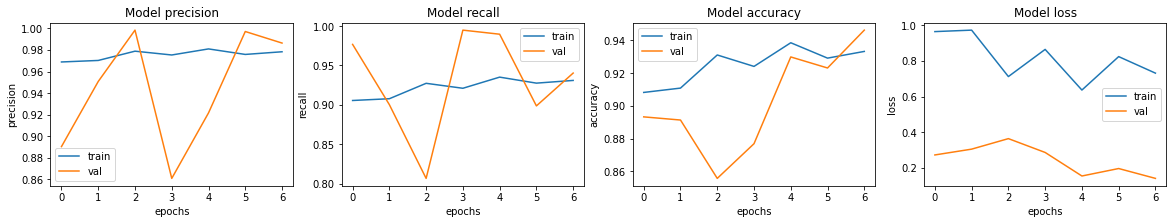

In [133]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 4. 결과 시각화

- model.evaluate 안됐어가지고 따로 label들을 얻어서 pred했었는데 그 과정에서 오류가 발견되어 해결됨
- 그래서 둘다 작성함

In [109]:
test_img, test_lab = tuple(zip(*test_ds))
len(test_img)

1

In [113]:
test_img = test_img[0]
test_label = test_lab[0]

In [134]:
pred_prob = model.predict(test_img)

In [139]:
pred = [1 if x >= 0.5 else 0 for x in pred_prob]
true = [1 if x == True else 0 for x in test_lab[0]]

In [141]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76       234
           1       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



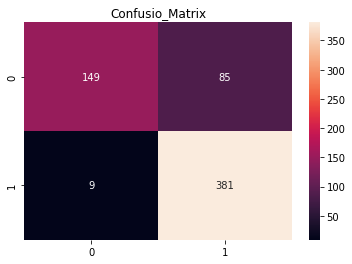

In [144]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot = True, fmt='d')
plt.title('Confusion_Matrix')
plt.show()

In [147]:
corr = [1 if x == y else 0 for x, y in zip(true, pred)]
print('TEST Accuracy :', round(sum(corr)/len(true),2)) # 반올림해서 85%도 85%지 아무렴...

TEST Accuracy : 0.85


In [148]:
loss, accuracy, precision, recall = model.evaluate(test_ds) # test_ds 고치고나서는 evaluate 가능
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

1/1 [==============================] - 7s 7s/step - loss: 0.4481 - accuracy: 0.8494 - precision: 0.8176 - recall: 0.9769
Loss: 0.44810807704925537,
Accuracy: 0.8493589758872986,
Precision: 0.8175965547561646,
Recall: 0.9769230484962463


## 회고

- resnet 공식 문서에 구현 되어있는 코드들에서 l2 규제 관련해서는 이해가 깊지 않아서 최소한으로 간추린 버전의 resnet18을 구현하였다. 

- resnet을 처음 구현하였을때, 차원이 맞지 않아 add가 되지 않았던 문제가 있었는데 diagram들을 살펴보니 stride를 이용하여 차원을 맞춰 더하는 것을 확인하였다. 

- 구현에 대한 공부가 더 필요할 것으로 보이나 현재로써는 처음으로 model에 대한 filter, conv 등의 table 정보로 모델을 구현했던 시도였다. 다양한 모델들을 보고 단순하게라도 따라하려는 시도를 해보아야 할 것 같다.

- augmentation 방법은 다양하게 있으나 현재는 NODE에서 구현한 버전으로 사용하였으며 tensorflow.data의 ImageDataGenerator를 쓰면 현재의 코드를 더욱 간소화 할 수 있을 것으로 판단된다.

- 현재 데이터셋에서는 augmentation에 따른 accuracy 정도가 꽤 차이가 보이는 것 같다. 모델 구성하는데 시간을 많이 써서 최대한 여러 자료들에서 사용하는 방법들을 가져다 사용했는데 성공적으로 작동한 것 같아서 다행이라는 생각이 들었다.

- 학습까지 다 됐는데 evaluate이 안되서 멘붕해가지고 test set에서 image array만 불러오는 법도 고민했었다. (tensor가 load하는 순서를 잘 몰라서 결국 pass) 그런데 이게 path의 문제로 파일들을 저장해두었던 filenames 객체가 아닌 data파일이 존재하는 최상단 폴더 TEST_PATH가 들어가서 잘못된 것이였다....그래서 file을 찾지 못하고 tensor를 만들었기 때문에 evaluate 에서 error가 났던 것으로 추정이 된다.

- Augmentation 없는 resnet18 모델도 실험해봤는데, 학습에서는 잘해놓고 test accuracy만 몹시 낮아서 당황했다. data가 pneumonia에 치중 되있었기 때문에 학습에서는 accuracy가 높았을 것으로 생각된다.